In [103]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import yaml
from collections import defaultdict
import pickle as pkl
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import respy as rp

from python.auxiliary_setup import *
from python.auxiliary_weighting import *
from python.auxiliary_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Observed-Data" data-toc-modified-id="Observed-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Observed Data</a></span></li><li><span><a href="#Data-Moments" data-toc-modified-id="Data-Moments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Moments</a></span></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weighting Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Criterion Function</a></span></li><li><span><a href="#Estimation-Exercise" data-toc-modified-id="Estimation-Exercise-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Estimation Exercise</a></span><ul class="toc-item"><li><span><a href="#Estimation-for-one-parameter" data-toc-modified-id="Estimation-for-one-parameter-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Estimation for one parameter</a></span><ul class="toc-item"><li><span><a href="#Simulated-Moments" data-toc-modified-id="Simulated-Moments-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Simulated Moments</a></span></li><li><span><a href="#Optimization-Procedure" data-toc-modified-id="Optimization-Procedure-6.1.2"><span class="toc-item-num">6.1.2&nbsp;&nbsp;</span>Optimization Procedure</a></span><ul class="toc-item"><li><span><a href="#Upper-and-Lower-Bounds" data-toc-modified-id="Upper-and-Lower-Bounds-6.1.2.1"><span class="toc-item-num">6.1.2.1&nbsp;&nbsp;</span>Upper and Lower Bounds</a></span></li><li><span><a href="#Constraints" data-toc-modified-id="Constraints-6.1.2.2"><span class="toc-item-num">6.1.2.2&nbsp;&nbsp;</span>Constraints</a></span></li><li><span><a href="#Optimize" data-toc-modified-id="Optimize-6.1.2.3"><span class="toc-item-num">6.1.2.3&nbsp;&nbsp;</span>Optimize</a></span></li></ul></li></ul></li><li><span><a href="#Chatter-in-the-Criterion-Function" data-toc-modified-id="Chatter-in-the-Criterion-Function-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Chatter in the Criterion Function</a></span><ul class="toc-item"><li><span><a href="#Changing-the-Simulation-Seed" data-toc-modified-id="Changing-the-Simulation-Seed-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Changing the Simulation Seed</a></span></li><li><span><a href="#Multiple-Simulation-Seeds" data-toc-modified-id="Multiple-Simulation-Seeds-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Multiple Simulation Seeds</a></span></li><li><span><a href="#Changing-the-Simulation-Seed-for-increasing-Sample-Size-of-Simulated-Agents" data-toc-modified-id="Changing-the-Simulation-Seed-for-increasing-Sample-Size-of-Simulated-Agents-6.2.3"><span class="toc-item-num">6.2.3&nbsp;&nbsp;</span>Changing the Simulation Seed for increasing Sample Size of Simulated Agents</a></span></li><li><span><a href="#Changing-the-Simulation-Seed-for-increasing-Sample-Size-of-Simulated-and-Observed-Agents" data-toc-modified-id="Changing-the-Simulation-Seed-for-increasing-Sample-Size-of-Simulated-and-Observed-Agents-6.2.4"><span class="toc-item-num">6.2.4&nbsp;&nbsp;</span>Changing the Simulation Seed for increasing Sample Size of Simulated <em>and</em> Observed Agents</a></span></li></ul></li><li><span><a href="#Moving-away-from-the-Optimum" data-toc-modified-id="Moving-away-from-the-Optimum-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Moving away from the Optimum</a></span><ul class="toc-item"><li><span><a href="#Retrieving-the-true-Parameter-Vector" data-toc-modified-id="Retrieving-the-true-Parameter-Vector-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Retrieving the true Parameter Vector</a></span></li></ul></li><li><span><a href="#Derivative-Based-Optimization-Algorithm" data-toc-modified-id="Derivative-Based-Optimization-Algorithm-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Derivative-Based Optimization Algorithm</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

The simulated method of moments approach to estimating model parameters is to minimize a certain distance between observed moments and simulated moments with respect to the parameters that generate the simulated model.

Denote $X$ our observed data and $m(X)$ the vector of observed moments. To construct the criterion function, we use the parameter vector $\theta$ to simulate data from the  model $\hat{X}$. We can then calculate the simulated moments $m(\hat{X}| \theta)$.

The criterion function is then given by 

\begin{equation}
\psi(\theta) = (m(X) - m(\hat{X}| \theta))'\Omega(m(X) - m(\hat{X}| \theta))
\end{equation}

where the difference between observed and simulated moments $(m(X) - m(\hat{X}| \theta))$ constitutes a vector of the dimension $1\times M$ with $1,..,M$ denoting the number of moments. The $M\times M$ weighting matrix is given by $\Omega$. 

The SMM estimator is defined as the solution to 

\begin{equation}
\hat{\theta}(\Omega) = \underset{\theta}{\operatorname{argmin}} \psi(\theta).
\end{equation}

The criterion function is thus a strictly positive scalar and the estimator depends on the choice of moments $m$ and the weighting matrix $\Omega$. The weighting matrix applies some scaling for discrepancies between the observed and simulated moments. If we use the identity matrix, each moment is given equal weight and the criterion function reduces to the sum of squared moment deviations. 

Aside from the choice of moments and weighting matrix, some other important choices that influence the the estimation are the simulator itself and the algorithm and specifications for the optimization procedure. Many explanations for simulated method of moments estimation also feature the number of simulations as a factor that is to be determined for estimation. We can ignore this factor for now since we are working with a large simulated dataset.

In the following we will set up the data, moments and weighting matrix needed to construct the criterion function and subsequently try to estimating the parameters of the model using this SMM setup.

##  Observed Data

We generate our model and data using [respy](https://respy.readthedocs.io/en/latest/) and a simple Robinson Crusoe model. In this model, the agent, Robinson Crusoe, in each time period decides between two choice options: working (i.e. going fishing) or spending time in the hammock. 

We can use respy to simulate the data for this exercise.

In [5]:
params_true, options = rp.get_example_model("robinson_crusoe_basic", with_data=False)

In [6]:
# Generate observed data from model.
simulate = rp.get_simulate_func(params_true, options)
data_obs = simulate(params_true)

Let's take a look at the model specifications.

In [7]:
params_true 

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00
inadmissibility_penalty inadmissibility_penalty -20.00

In [8]:
options

{'n_periods': 10,
 'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"},
 'core_state_space_filters': ["period > 0 and exp_fishing == period and lagged_choice_1 == 'hammock'",
  "exp_fishing == 0 and lagged_choice_1 == 'fishing'"]}

In [9]:
data_obs.head(10)

Experience_Fishing Lagged_Choice_1  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0         hammock              2.048628   
           1                        1         fishing              0.147087   
           2                        1         hammock              0.903027   
           3                        2         fishing              0.339405   
           4                        2         hammock              2.822820   
           5                        3         fishing              2.015148   
           6                        3         hammock              5.802097   
           7                        4         fishing              0.429942   
           8                        4         hammock              0.216153   
           9                        4         hammock              7.604617   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.866250   
           1                             1              1.421523   
           2                             1             -0.351595   
           3                             1             -0.930422   
           4                             1             -0.420713   
           5                             1              2.056790   
           6                             1             -0.090973   
           7                             1              1.443708   
           8                             1             -0.298857   
           9                             1             -0.666748   

                   Meas_Error_Wage_Hammock   Choice       Wage  Discount_Rate  \
Identifier Period                                                               
0          0                             1  fishing   2.048628           0.95   
           1                             1  hammock        NaN           0.95   
           2                             1  fishing   0.998000           0.95   
           3                             1  hammock        NaN           0.95   
           4                             1  fishing   3.447800           0.95   
           5                             1  hammock        NaN           0.95   
           6                             1  fishing   7.832012           0.95   
           7                             1  hammock        NaN           0.95   
           8                             1  hammock        NaN           0.95   
           9                             1  fishing  11.344756           0.95   

                   Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period                                              
0          0                                -1      2.048628   
           1                                -1      0.162556   
           2                                -1      0.998000   
           3                                -1      0.414550   
           4                                -1      3.447800   
           5                                -1      2.720165   
           6                                -1      7.832012   
           7                                -1      0.641398   
           8                                -1      0.322463   
           9                                -1     11.344756   

                   Flow_Utility_Fishing  Value_Function_Fishing  \
Identifier Period                                                 
0          0                   1.048628               19.513202   
           1                  -0.837444               16.864110   
           2                  -0.002000               15.655857   
           3                  -0.585450               13.941609   
           4                   2.447800               14.749573   
           5                   1.720165   

## Data Moments

For the setup of the estimation we first have to choose a set of moments that we will use to match the observed data and the simulated model. For this model we include two sets of moments: 

1. The first set are Robinson's **choice frequencies** (choice frequencies here refers to the share of agents that have chosen a specific option) for each period. 
2. The second set are moments that characterize the **wage distribution** for each period, i.e. the mean of the wage of all agents that have chosen fishing in a given period and the standard deviation of the wages. 

In addition to the data, we need the complete set of potential choice options for Robinson. Respy lets us extract them from the model parameters and options.

In [10]:
#optim_paras = process_params_and_options(params_true, options)[0]
#choice_options_robinson = optim_paras["choices"].keys()

We need a function that computes the set of moments on the observed and simulated data.

In [11]:
def calc_choice_frequencies(df):
    """Calculate choice frequencies"""
    return df.groupby("Period").Choice.value_counts(normalize=True).unstack()

In [12]:
def calc_wage_distribution(df):
    """Calculate wage distribution."""
    return df.groupby(["Period"])["Wage"].describe()[["mean", "std"]]

In [16]:
calc_moments = {"choice_frequencies":calc_choice_frequencies, 
                "wage_distribution":calc_wage_distribution}

In [17]:
def replace_nans(df):
    """Replace missing values in data."""
    return df.fillna(0)

Now we are ready to calculate the moments.

In [21]:
observed_moments = {"choice_frequencies": replace_nans(calc_moments["choice_frequencies"](data_obs)),
                    "wage_distribution": replace_nans(calc_moments["wage_distribution"](data_obs))}

In [22]:
print('Choice Frequencies')
print(observed_moments["choice_frequencies"])
print('\n Wage Distribution')
print(observed_moments["wage_distribution"])

Choice Frequencies
Choice  fishing  hammock
Period                  
0         0.549    0.451
1         0.416    0.584
2         0.463    0.537
3         0.465    0.535
4         0.443    0.557
5         0.447    0.553
6         0.424    0.576
7         0.409    0.591
8         0.415    0.585
9         0.293    0.707

 Wage Distribution
            mean       std
Period                    
0       2.294384  2.229436
1       2.890082  2.890317
2       2.806003  2.486185
3       3.253748  3.119447
4       3.656316  4.174901
5       3.611139  4.200553
6       3.822057  3.351915
7       4.058608  4.053294
8       4.180347  3.766655
9       5.261872  4.843979


## Weighting Matrix

Next we specify a weighting matrix. It needs to be a square matrix with the same number of diagonal elements as there are moments. One option would be to use the identity matrix, but we use a weighting matrix that adjusts for the variance of each moment. The variances for the moments are constructed using a bootstrapping procedure. 

In [38]:
def get_weighting_matrix(data, calc_moments, num_boots, num_agents_msm):
    """ Compute weighting matrix for estimation with MSM."""
    np.random.seed(123)

    index_base = data.index.get_level_values("Identifier").unique()

    moments_sample = list()
    for _ in range(num_boots):
        ids_boot = np.random.choice(index_base, num_agents_msm, replace=False)
        moments_boot = [calc_moments[key](data.loc[ids_boot, :]) for key in calc_moments.keys()]

        moments_boot = rp.get_flat_moments(moments_boot)

        moments_sample.append(moments_boot)

    moments_var = np.array(moments_sample).var(axis=0)
    weighting_matrix = np.diag(moments_var ** (-1))

    return np.nan_to_num(weighting_matrix)

In [43]:
W = get_weighting_matrix(data_obs, calc_moments, 300, 500)

In [44]:
pd.DataFrame(W)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,3695.027839,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.000000,3947.610126,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.000000,4108.385415,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,3436.793548,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,3898.62602,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,3876.586708,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4425.082469,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3957.581063,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,3829.180431,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5282.186121,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


## Criterion Function 

We have collected the observed data for our model, chosen the set of moments we want to use for estimation and defined a weighting matrix based on these moments. We can now set up the criterion function to use for estimation. 

As already discussed above, the criterion function is given by the weighted square product of the difference between observed moments $m(X)$ and simulated moments $m(\hat{X}| \theta)$. Trivially, if we have that $m(X) = m(\hat{X}| \theta)$, the criterion function returns a value of 0. Thus, the closer $\theta$ is to the real parameter vector, the smaller should be the value for the criterion function. 

In [48]:
criterion_msm = rp.get_msm_func(params_true, options, calc_moments, replace_nans, observed_moments, W)

Criterion function at the true parameter vector:

In [50]:
fval = criterion_msm(params_true)
fval

0.0

We can plot the criterion function to examine its behavior around the minimum in more detail. The plots below show the criterion function at varying values of all parameters in the the paramter vector.

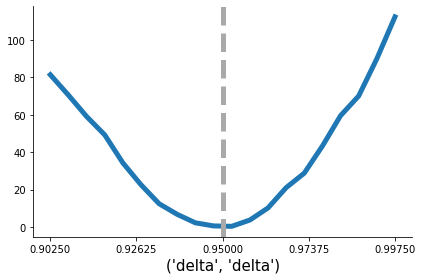

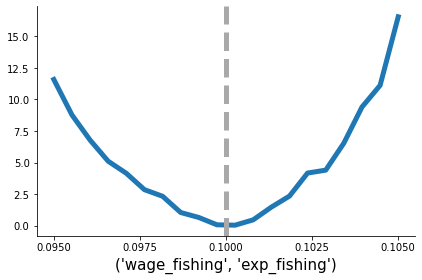

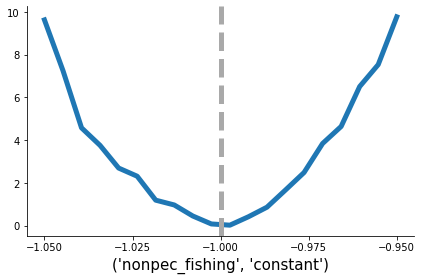

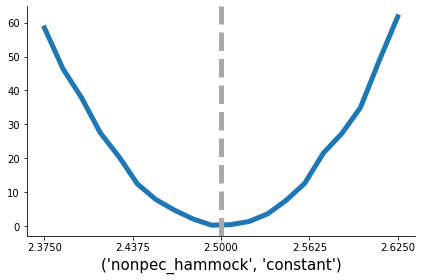

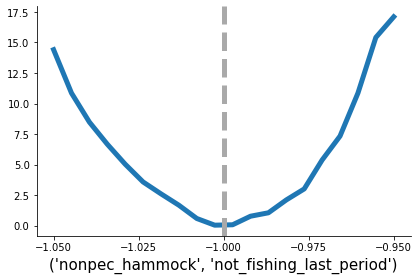

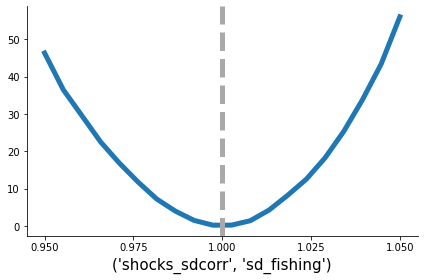

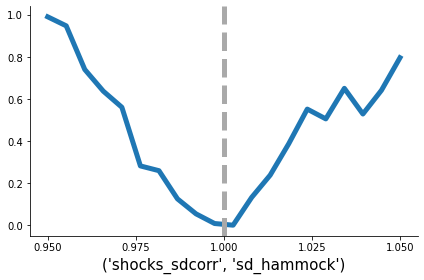

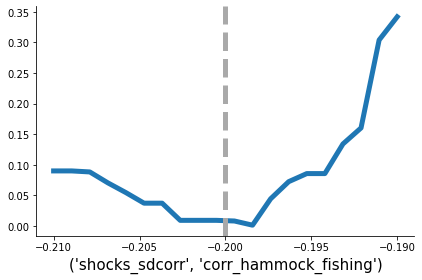

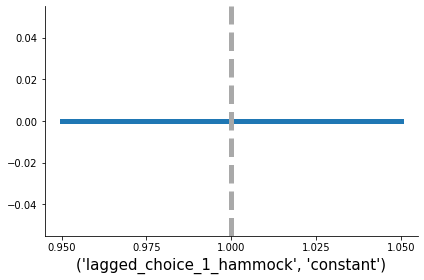

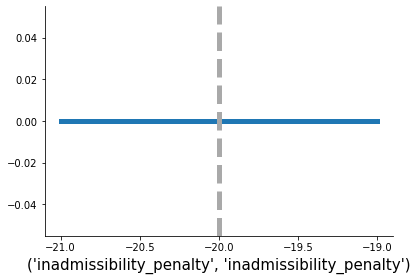

In [140]:
plot_criterion_params(params_true,list(params_true.index), criterion_msm, 0.05)

This depiction for most parameters conceals the fact that the criterion function is not a smooth function of our parameter values. We can reveal this property if we 'zoom in' on the function far enough. The plots below show the criterion function for varying values of *delta* around the true minimum value of 0.95. We can see that the function exhibits small plateaus and is thus not completely smooth. 

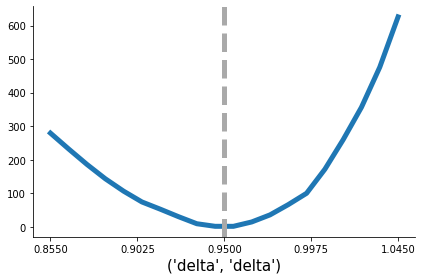

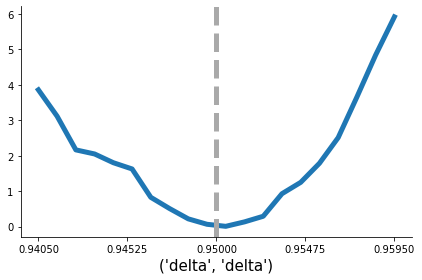

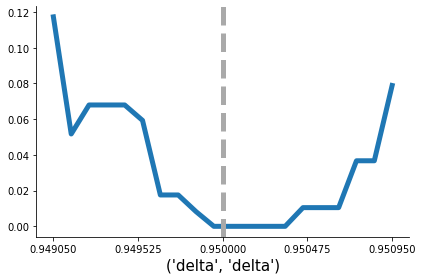

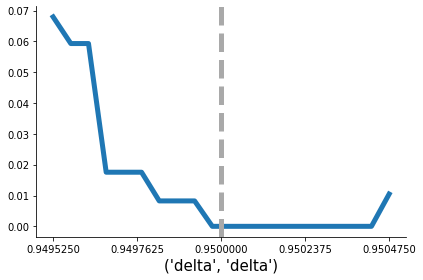

In [139]:
for radius in [0.1, 0.01, 0.001, 0.0005]:
    plot_criterion_params(params_true, list(params_true.index)[0:1], criterion_msm, radius)

##  Estimation Exercise

In the following we will conduct a simulation exercise to estimate the parameter vector using our criterion function and weighting matrix. We will begin by simulating data using the new parameter vector and examine how the simulated moments differ from the observed ones. We will then use an optimizer to minimize the criterion function in order to retrieve the true parameter vector. Additionally, we will explore how the criterion function behaves if we change the simulation seed, move away from the true values and test the optimization for a derivative-based optimization algorithm.

### Estimation for one parameter

For now, our candidate parameter vector will just differ in *delta* from the true parameters.

In [66]:
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

#### Simulated Moments

We can now use our model to simulate data using the candidate parameter vector. We can see that the choice frequencies and wage distribution differ from the moments of the observed dataset.

In [67]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

We can plot the moments to compare the choice frequencies for each period.

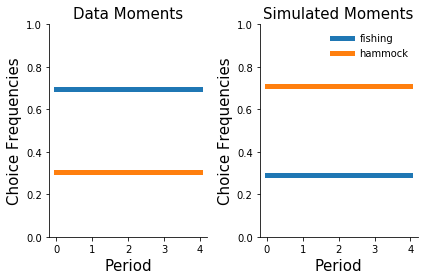

In [68]:
plot_moments_choices(moments_obs, moments_sim)

The plots below show the mean and the standard deviation in the wages for each period.

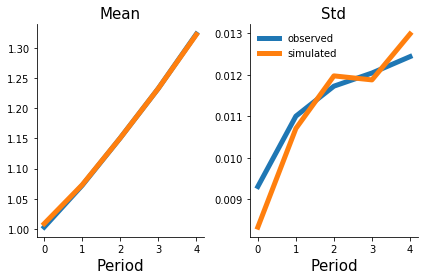

In [69]:
plot_moments_wage(moments_obs, moments_sim)

The criterion function value for the candidate parameter vector is not zero.

In [70]:
fval = criterion_smm(params_cand, options, W, moments_obs, choice_options_robinson)
fval

1637.6587458130693

#### Optimization Procedure

We will now use an optimization procedure to retrieve the true parameter vector. For the optimization we can use [estimagic](https://estimagic.readthedocs.io/en/latest/index.html). In order to minimize the criterion function we need estimagic's `minimize` function.



In [71]:
from estimagic.optimization.optimize import minimize

We have verified above that the criterion function gives a value of 0 for the true parameter vector. Before we try different parameter specifications, we can check whether an optimizer recognizes the true vector as the minimum of our criterion function.

In [72]:
# Save criterion function arguments in a dictionary to pass onto the optimzer.
criterion_kwargs = dict()
criterion_kwargs["weighting_matrix"] = W
criterion_kwargs["options"] = options
criterion_kwargs["choice_options"] = list(choice_options_robinson)
criterion_kwargs["moments_obs"] = moments_obs

As the code below shows, the optimization algorithm recognizes the true parameter vector as the minimum of the criterion function as it returns a function value of 0 and the true parameter values.

In [73]:
rslt = minimize(criterion=criterion_smm,
                params=params_true,
                algorithm="nlopt_bobyqa",
                criterion_kwargs= criterion_kwargs,
               )
rslt[0]

{'criterion': 0.0,
 'x': array([ 0.95 ,  0.07 , -0.1  ,  1.046,  0.01 ,  0.01 ,  0.   ]),
 'n_evaluations': 124,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

##### Upper and Lower Bounds

We can help the optimizer by specifying bounds for the parameters. Since we know the true parameters in the case of this model, we can just pick upper and lower bounds that are fairly close to the true values of the parameters to aid the optimizer in the search for the optimum. By default, the upper and lower bounds are set to $\infty$ and $-\infty$, so specifying upper and lower bounds substantially reduces the range of parameter values that the optimizer can potentially cover.

For optimization with estimagic, we can specify bounds by adding the columns *'lower'* and *'upper'* to the dataframe that contains the parameter values.

In [74]:
params_cand['lower'] = [0.89, 0.066, -0.11, 1.04, 0, 0, 0]
params_cand['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]
params_cand

value  lower  upper
category       name                                     
delta          delta                 0.930  0.890  0.980
wage_fishing   exp_fishing           0.070  0.066  0.072
nonpec_fishing constant             -0.100 -0.110 -0.095
nonpec_hammock constant              1.046  1.040  1.055
shocks_sdcorr  sd_fishing            0.010  0.000  0.100
               sd_hammock            0.010  0.000  0.100
               corr_hammock_fishing  0.000  0.000  0.100

##### Constraints

Additionally we hold all other parameters fixed for now to aid the optimizer in finding the optimal value for *delta*.

In [75]:
# Define base constraints to use for the rest of the notebook.
constr_base = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    {"loc": "delta", "type": "fixed"},
    {"loc": "wage_fishing", "type": "fixed"},
    {"loc": "nonpec_fishing", "type": "fixed"},
    {"loc": "nonpec_hammock", "type":"fixed"},
    {"loc": "shocks_sdcorr", "type": "fixed"},
]

In [76]:
# Remove constraint for delta.
constr = constr_base.copy()
constr.remove({"loc": "delta", "type": "fixed"})

##### Optimize

We can now optimize the criterion function with respect to the parameter vector. The optimizer manages to reach a function value of 0 and finds an approximately correct *delta* for our model. 

This exercise again reveals that we are dealing with a non-smooth criterion function. The optimizer does not return the exact value of 0.95 for *delta* because of the little plateaus we saw when zooming into the criterion function. As the plot shows, there is a small area around the true value for *delta* that also returns a function value of 0 and might thus be picked by the optimizer.

In [77]:
rslt = minimize(criterion=criterion_smm,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_kwargs=criterion_kwargs,
               )
rslt[0]

{'criterion': 0.0,
 'x': array([0.95000841]),
 'n_evaluations': 23,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

### Chatter in the Criterion Function

In this exercise we explore the sensitivity of the criterion function to the choice of simulation seed and number of agents.

#### Changing the Simulation Seed

As shown above, the optimizer manages to find a function value of exactly 0 for the true parameter vector. This is the case because respy controls the realization of random elements in the simulation process via a simulation seed. The model thus always simulates the exact same dataset for a given parameter vector. Our criterion function becomes exactly 0 at the true parameter vector because for this vector, the observed and simulated data are identical.

Changing the simulation seed results in simulated moments that, even for the true parameter vector, are never completely equal to the observed moments. 

Let's estimate the model with a different simulation seed.

In [78]:
options_new_seed = options.copy()
options_new_seed["simulation_seed"] = 400

We can see that the criterion function is not exactly 0 anymore for the true parameter vector.

In [79]:
criterion_smm(params_true, options_new_seed, W, moments_obs, choice_options_robinson)

10.112579552372829

Our optimizer thus also does not return a function value of 0 for the true parameter vector.

In [80]:
criterion_kwargs_new_seed = criterion_kwargs.copy()
criterion_kwargs_new_seed["options"] = options_new_seed

In [81]:
rslt_new_seed = minimize(criterion=criterion_smm,
                        params=params_true,
                        algorithm="nlopt_bobyqa",
                        constraints=constr,
                        criterion_kwargs=criterion_kwargs_new_seed,
                        )
rslt_new_seed[0]

{'criterion': 10.04471065167186,
 'x': array([0.95006584]),
 'n_evaluations': 30,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

Since the optimizer does not even recognize the true parameter vector, it is also not able to reach a criterion function  value of 0 for a different parameter vector.

In [82]:
rslt_new_seed = minimize(criterion=criterion_smm,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_kwargs=criterion_kwargs_new_seed,
                    )
    
rslt_new_seed[0]

{'criterion': 10.112579552372829,
 'x': array([0.94998508]),
 'n_evaluations': 23,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

#### Multiple Simulation Seeds

The section above shows what happens to the criterion function if we change the seed for simulating the data. In the sections below we will repeat this exercise for multiple seeds and explore what happens if we increase the number of simulated as well as observed agents in our model.

In [83]:
# List of seeds, includes true simulation seed of 132.
seeds = list(range(120,140,1))

In [84]:
# Define other inputs for criterion function
criterion_args = copy.deepcopy(criterion_kwargs)
criterion_args['params'] = params_true.copy()

The plot below shows the criterion function for different simulation seeds, including the true one. We can seed that different seeds lead to different fits between the simulated and observed data, with some seeds performing worse than others. Only the true seed leads to a function value of 0.

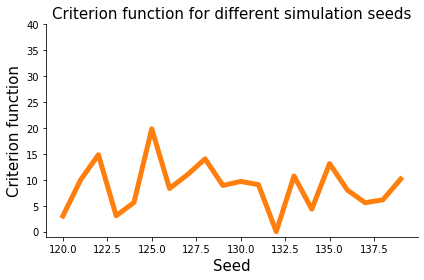

In [85]:
plot_chatter(seeds, criterion_smm, criterion_args)

#### Changing the Simulation Seed for increasing Sample Size of Simulated Agents

We now repeat this exercise for an increasing number of simulated agents. As the plot below shows, increasing the number of simulated agents reduces the chatter considerably but the criterion function remains consistently above zero. Only the simulated sample of 1000 agents at the true simulation seed reaches a function of zero, since, as discussed before, the simulated sample is identical to the observed one for this calibration.

In [86]:
# Changing the number of agents.
num_agents = [500, 1000, 5000, 10000, 50000]

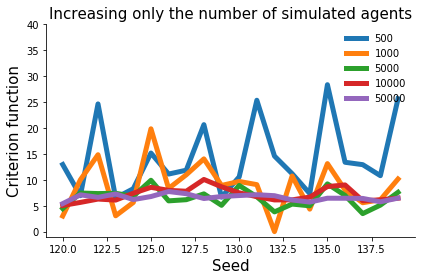

In [87]:
plot_chatter_numagents_sim(seeds, num_agents, criterion_smm, criterion_args)

#### Changing the Simulation Seed for increasing Sample Size of Simulated *and* Observed Agents

We now increase not only the number of simulated agents but also the number of observed agents in our sample. Doing so decreases the chatter in the criterion function as before but also levels out the function around 0 for all simulation seeds. For large enough samples of observed and simulated agents the choice of simulation seed is thus irrelevant.

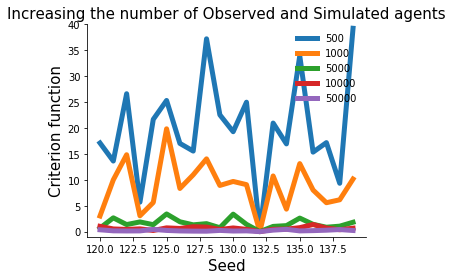

In [88]:
plot_chatter_numagents_both(seeds, num_agents, get_moments, criterion_smm, criterion_args)

*Note*: In contrast to the previous plot, we can see that the function reaches a value of 0 at the true simulation seed for all quantities of agents. This is the case because we now simultaneously increase the number of both simulated and observed agents while the observed sample remained untouched in the previous plot. Increasing the number of agents simultaneously for both groups creates identical samples for the true simulation seed at each quantity of agents. 

### Moving away from the Optimum

For the next exercise we explore what happens to the criterion function if we move away from the optimum. We do this in a controlled fashion by changing the parameter values for *delta* and *wage_fishing* and fixing the latter in the constraints. Doing so should lead *delta* to move away from its optimal value of 0.95 during optimization.

In [100]:
params_cand.loc["wage_fishing", "value"] = 0.072
params_cand

value  lower  upper
category       name                                        
delta          delta                 0.923983  0.890  0.980
wage_fishing   exp_fishing           0.072000  0.066  0.072
nonpec_fishing constant             -0.100000 -0.110 -0.095
nonpec_hammock constant              1.046000  1.040  1.055
shocks_sdcorr  sd_fishing            0.010000  0.000  0.100
               sd_hammock            0.010000  0.000  0.100
               corr_hammock_fishing  0.000000  0.000  0.100

The optimizer cannot retrieve the true parameter and does not reach a value of 0.

In [92]:
rslt_wrong_fix = minimize(criterion=criterion_smm,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_kwargs=criterion_kwargs,
               )
rslt_wrong_fix[0]

{'criterion': 202.81733689354155,
 'x': array([0.92398337]),
 'n_evaluations': 25,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

#### Retrieving the true Parameter Vector

We now repeat the estimation with the new parameter vector and free up *wage_fishing* to retrieve the optimal values for both parameters.

The parameter for *wage_fishing* is still 0.072 since we fixed it for the prior estimation:

In [94]:
params_cand.loc[:,'value'] = rslt_wrong_fix[1][['value']]
params_cand

value  lower  upper
category       name                                        
delta          delta                 0.923983  0.890  0.980
wage_fishing   exp_fishing           0.072000  0.066  0.072
nonpec_fishing constant             -0.100000 -0.110 -0.095
nonpec_hammock constant              1.046000  1.040  1.055
shocks_sdcorr  sd_fishing            0.010000  0.000  0.100
               sd_hammock            0.010000  0.000  0.100
               corr_hammock_fishing  0.000000  0.000  0.100

We now free up *wage_fishing* in the constraints in addition to *delta*.

In [98]:
# Adjust constraints to free up both delta and wage_fishing.
constr_u = constr_base.copy()
constr_u.remove({'loc': 'delta', 'type': 'fixed'})
constr_u.remove({'loc': 'wage_fishing', 'type': 'fixed'})

Freeing up the non-optimal *wage_fishing* improves the estimates. The criterion function value is much closer to 0 and the optimizer manages to retrieve the true parameter values quite closely.

In [99]:
rslt_unfix = minimize(criterion=criterion_smm,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr_u,
                criterion_kwargs=criterion_kwargs,
               )
rslt_unfix[0]

{'criterion': 8.745208664896812e-06,
 'x': array([0.94997942, 0.07000042]),
 'n_evaluations': 91,
 'n_evaluations_jacobian': 0,
 'n_evaluations_hessian': 0,
 'n_constraints': 0,
 'n_constraints_equality': 0,
 'n_constraints_inequality': 0,
 'optimization_status': 'success'}

For easier comparison, we can compute the difference between the true and estimated value:

In [97]:
deviation = params_true['value'] - rslt_unfix[1]['value']
deviation

category        name                
delta           delta                   2.057875e-05
wage_fishing    exp_fishing            -4.167183e-07
nonpec_fishing  constant                0.000000e+00
nonpec_hammock  constant                0.000000e+00
shocks_sdcorr   sd_fishing              0.000000e+00
                sd_hammock              0.000000e+00
                corr_hammock_fishing    0.000000e+00
Name: value, dtype: float64

### Derivative-Based Optimization Algorithm

So far we have used only one optimization algorithm to estimate the parameter vector. The algorithm we used, BOBYQA (Bound Optimization by Quadratic Approximation), is a derivative-free optimization algorithm which works fairly well on our criterion function. As discussed above, our criterion function is a step function that contains plateaus for certain ranges of parameter values. An important implication of this property is that we cannot calculate proper derivatives and thus derivative-based optimization algorithms will not work to estimate the parameters. 

To demonstrate this problem, we will now try to estimate the parameters using an optimization algorithm that does use derivatives during optimization.

In [48]:
# Define candidate parameter vector and constraints.
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

params_cand['lower'] = [0.89, 0.066, -0.11, 1.04, 0, 0, 0]
params_cand['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]

constr = constr_base.copy()
constr.remove({"loc": "delta", "type": "fixed"})

We try the L-BFGS-B (Limited-Memory-Broyden–Fletcher–Goldfarb–Shanno with box constraints) algorithm. As shown below, L-BFGS-B fails and the optimizer returns the same parameter vector that we used as an input. 

In [48]:
rslt = minimize(criterion=criterion_smm,
                params=params_cand,
                algorithm="scipy_L-BFGS-B",
                constraints=constr,
                criterion_kwargs=criterion_kwargs,
               )
rslt[0]

{'status': 0,
 'message': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'x': array([0.93]),
 'success': True,
 'criterion': 1637.6587458130693,
 'n_evaluations': 2,
 'jacobian': array([0.]),
 'hessian': None,
 'n_evaluations_jacobian': None,
 'n_evaluations_hessian': None,
 'n_iterations': 0,
 'max_constraints_violations': None,
 'hessian_inverse': <1x1 LbfgsInvHessProduct with dtype=float64>,
 'optimization_status': 'success'}

## References

* Adda, J., & Cooper, R. W. (2003). *Dynamic Economics: Quantitative Methods and Applications*. MIT press.


* Adda, J., Dustmann, C., & Stevens, K. (2017). The Career Costs of Children. *Journal of Political Economy*, 125(2), 293-337.


* Andrews, I., Gentzkow, M., & Shapiro, J. M. (2017). Measuring the Sensitivity of Parameter Estimates to Estimation Moments. *The Quarterly Journal of Economics*, 132(4), 1553-1592.


* Bruins, M., Duffy, J. A., Keane, M. P., & Smith Jr, A. A. (2018). Generalized Indirect Inference for Discrete Choice Models. *Journal of econometrics*, 205(1), 177-203.


* Davidson, R., & MacKinnon, J. G. (2004). *Econometric Theory and Methods (Vol. 5)*. New York: Oxford University Press.


* Evans, R. W. (2018, July 5). Simulated Method of Moments (SMM) Estimation. Retrieved November 30, 2019, from https://notes.quantecon.org/submission/5b3db2ceb9eab00015b89f93.


* Frazier, D. T., Oka, T., & Zhu, D. (2019). Indirect Inference with a Non-Smooth Criterion Function. *Journal of Econometrics*, 212(2), 623-645.
 
 
* Gourieroux, M., & Monfort, D. A. (1996). *Simulation-based econometric methods*. Oxford university press.


* McFadden, D. (1989). A Method of Simulated Moments for Estimation of Discrete Response Models without Numerical Integration. *Econometrica: Journal of the Econometric Society*, 995-1026.